In [56]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os, sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from model import ModelArgs, Transformer
from tokenizer import Tokenizer
from tinystories import get_tokenizer_model_path

# -----------------------------------------------------------------------------
start = "" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 25 # number of tokens generated in each sample
temperature = 0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 300 # retain only the top_k most likely tokens, clamp others to have 0 probability
tokenizer = "" # override the tokenizer model path
seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False # use PyTorch 2.0 to compile the model to be faster

softmax0_dir = '../out/softmax0-15m-2023_08_22_14_44_50'
softmax1_dir = "../out/softmax1-15m-2023_08_22_03_16_17"
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

@torch.no_grad()
def memoize_output(module, input, output):
   """Cache activation output of (a Transformer block)"""
   module.output = output

def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    gptconf = ModelArgs(**checkpoint_dict['model_args'])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    
    for block in model.layers:
        block.register_forward_hook(memoize_output)
    
    return model

def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", 'r') as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config['vocab_size']
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model='../tokenizer.model')
    return enc

model_softmax0 = load_model(softmax0_dir)
model_softmax1 = load_model(softmax1_dir)
enc = load_tokenizer(softmax1_dir)

def encode_prompt(start):
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
    start_ids = enc.encode(start, bos=True, eos=False)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    return x

# run generation
@torch.no_grad()
def generate(model=model_softmax0, prompt=start, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k):
    x = encode_prompt(prompt)
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature, top_k)
            x_blocks = torch.stack([block.output[0] for block in model.layers], dim=0) # (batch_size, seq_len, dim)
            yield enc.decode(y[0].tolist()), x_blocks

In [140]:
batch_activations = torch.stack([block.output for block in model_softmax0.layers], dim=1)
stats = torch.tensor([activation_stats(a.flatten().float()) for a in batch_activations])
skews = stats[:,0].tolist()
kurtoses = stats[:,1].tolist()
skews, kurtoses

([131.30299377441406], [4.298560619354248])

In [119]:
prompt = 'A long long time ago,'
y0, a0 = list(generate(model_softmax0, prompt))[0]
y1, a1 = list(generate(model_softmax1, prompt))[0]
y0, y1

('A long long time ago, there was a big, strong bear. The bear was very sad because he had no friends. One day, he saw a',
 'A long long time ago, there was a little girl named Lily. She loved to play with her toys and her friends. One day, L')

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from functools import partial

def activation_heatmap(a0, a1, layer=-1):
	"""
	Plot 2 heatmaps of activations side-by-side
	a0: Control, softmax0
	a1: Experiment, softmax1
	"""
	# Visualize some activations
	fig, axs = plt.subplots(2,1,figsize=(16, 4))
	for i,x in enumerate([a0, a1]):
		axs[i].imshow(x[layer-1], cmap='inferno')
		axs[i].set_title(f"Softmax{i} activations (layer={layer})", fontsize=16)
		axs[i].axis('off')
	plt.xlabel('Embedding Dim')
	plt.ylabel('Sequence Position')
	plt.tight_layout()
	plt.show()

def activation_histogram(a0, a1, layer=-1):
		"""
		Plot 2 histograms of activations side-by-side
		a0: Control, softmax0
		a1: Experiment, softmax1
		"""
		# Visualize some activations
		fig, axs = plt.subplots(1, 2, figsize=(12, 4))
		
		COLORS = ['cornflowerblue', 'mediumseagreen']
		
		# Plot histogram for a0
		for i,x in enumerate([a0, a1]):
			axs[i].hist(x[layer-1].flatten(), bins=20, color=COLORS[i], alpha=0.8, log=True)
			axs[i].set_title(f"Softmax{i} activations (layer={layer})")
		plt.xlabel('Activation Value')
		plt.ylabel('Count')
		plt.tight_layout()
		plt.show()

layer_slider = widgets.IntSlider(value=1, min=1, max=6, step=1, description='Layer:')

interactive_heat = widgets.interactive_output(partial(activation_heatmap, a0, a1), {'layer': layer_slider})
interactive_hist = widgets.interactive_output(partial(activation_histogram, a0, a1), {'layer': layer_slider})
display(widgets.VBox([layer_slider, interactive_heat, interactive_hist]))

In [121]:
def activation_stats(data):
  mean = data.mean()
  diffs = data - mean
  var = torch.mean(torch.pow(diffs, 2.0))
  std = torch.pow(var, 0.5)
  zscores = diffs / std
  skew = torch.mean(torch.pow(zscores, 3.0))
  kurtosis = torch.mean(torch.pow(zscores, 4.0)) - 3.0
  return kurtosis, skew

stats0 = torch.tensor([activation_stats(a.flatten().float()) for a in a0])
stats1 = torch.tensor([activation_stats(a.flatten().float()) for a in a1])
kurtosis0 = stats0[:,0]
kurtosis1 = stats1[:,0]
skew0 = stats0[:,1]
skew1 = stats1[:,1]
kurtosis0.mean().item(), kurtosis1.mean().item()

(214.83740234375, 98.43289947509766)

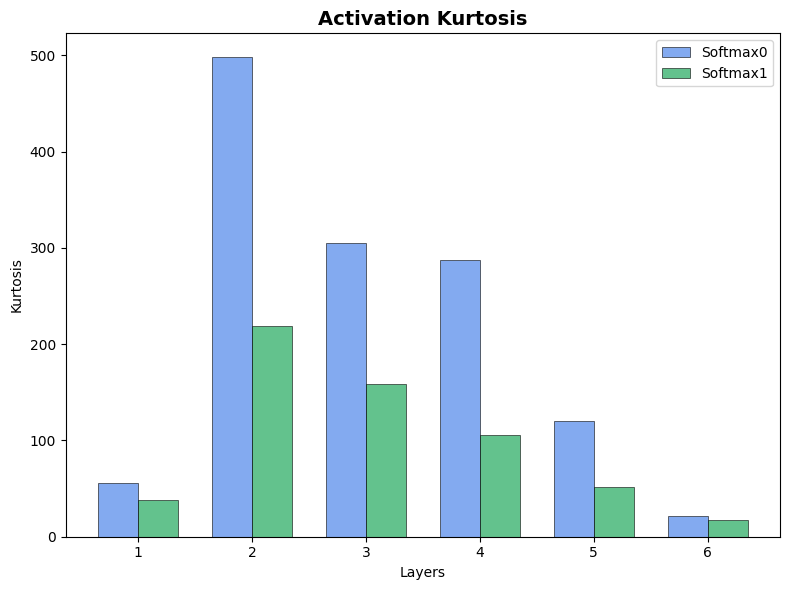

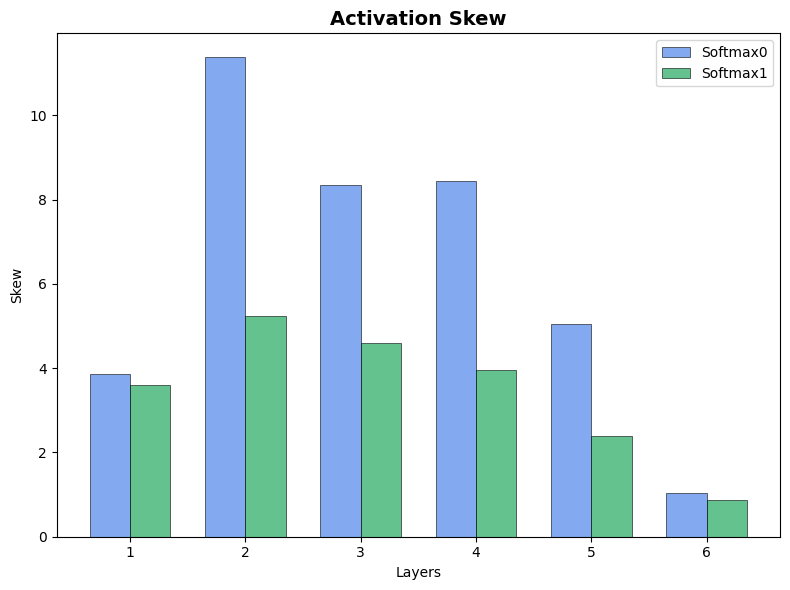

In [122]:
def activation_barchart(stat0, stat1, name='Kurtosis', xlabel='Layers', xticks=None):
    bar_width = 0.35
    x_positions = np.arange(len(stat0))
    plt.figure(figsize=(8,6))
    
    plt.bar(x_positions, stat0, bar_width, label='Softmax0', alpha=0.8, color='cornflowerblue', edgecolor='black', linewidth=0.5)
    plt.bar(x_positions + bar_width, stat1, bar_width, label='Softmax1', alpha=0.8, color='mediumseagreen', edgecolor='black', linewidth=0.5)
    
    plt.xlabel(xlabel)
    plt.xticks(x_positions + bar_width/2, x_positions + 1 if not xticks else xticks)
    plt.ylabel(name)
    
    plt.title(f'Activation {name}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()

activation_barchart(kurtosis0, kurtosis1, name='Kurtosis')
activation_barchart(skew0, skew1, name='Skew')

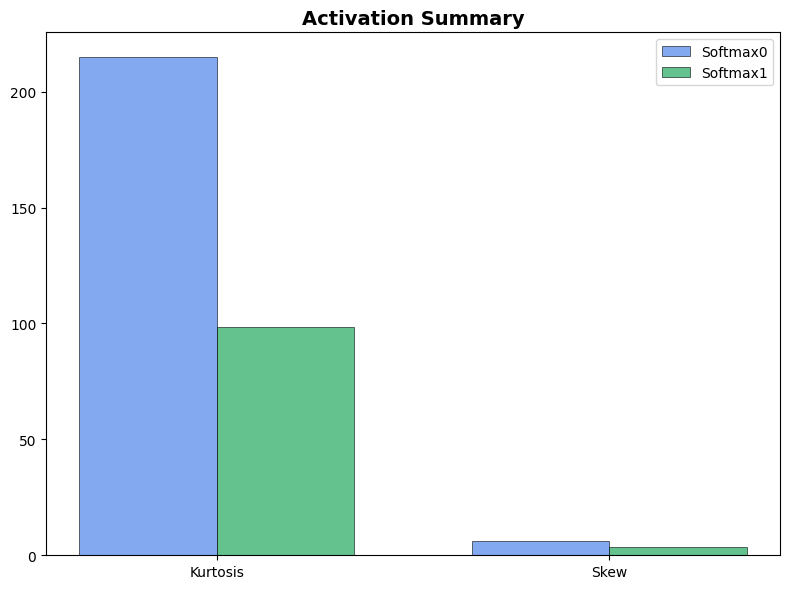

In [123]:
def summary_barchart(stat0, stat1, title):
    bar_width = 0.35
    x_positions = np.arange(len(stat0))
    plt.figure(figsize=(8,6))
    
    plt.bar(x_positions, stat0, bar_width, label='Softmax0', alpha=0.8, color='cornflowerblue', edgecolor='black', linewidth=0.5)
    plt.bar(x_positions + bar_width, stat1, bar_width, label='Softmax1', alpha=0.8, color='mediumseagreen', edgecolor='black', linewidth=0.5)
    
    plt.xticks(x_positions + bar_width/2, ['Kurtosis','Skew'])
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    
summary_barchart(stats0.mean(dim=0), stats1.mean(dim=0), title=f'Activations (mean of layers)')

In [131]:
print("For mean of layers")
print(f"Kurtosis: {kurtosis0.mean().item():.2f} (softmax0) vs {kurtosis1.mean().item():.2f} (softmax1)")
print(f"Skew: {skew0.mean().item():.2f} (softmax0) vs {skew1.mean().item():.2f} (softmax1)")

# Kurtosis and skew are proxies for quantisation performance.
# When we quantise, the entire model scales down to the same quantised spectrum.
# No layer gets special treatment - their own quantisation scale - so kurtosis
# over the whole model > averaging kurtosis over each layer.

whole_stats0 = activation_stats(a0.flatten().float())
whole_stats1 = activation_stats(a1.flatten().float())

print("For whole activations")
print(f"Kurtosis: {whole_stats0[0].item():.2f} (softmax0) vs {whole_stats1[0].item():.2f} (softmax1)")
print(f"Skew: {whole_stats0[1].item():.2f} (softmax0) vs {whole_stats1[1].item():.2f} (softmax1)")

For mean of layers
Kurtosis: 214.84 (softmax0) vs 98.43 (softmax1)
Skew: 6.35 (softmax0) vs 3.44 (softmax1)
For whole activations
Kurtosis: 131.30 (softmax0) vs 66.68 (softmax1)
Skew: 4.30 (softmax0) vs 2.32 (softmax1)
